In [1]:
import numpy as np
from graphviz import Digraph

A common substring of a collection of strings is a substring of every member of the collection. We say that a common substring is a longest common substring if there does not exist a longer common substring. For example, "CG" is a common substring of "ACGTACGT" and "AACCGTATA", but it is not as long as possible; in this case, "CGTA" is a longest common substring of "ACGTACGT" and "AACCGTATA".

Note that the longest common substring is not necessarily unique; for a simple example, "AA" and "CC" are both longest common substrings of 

Given: A collection of k
 (k≤100
) DNA strings of length at most 1 kbp each in FASTA format.

Return: A longest common substring of the collection. (If multiple solutions exist, you may return any single solution.)

[LCSM](https://rosalind.info/problems/lcsm/)

In [15]:
class PrefixTree(object):
    class Node(object):
        def __init__(self, tree_root, bp, string_id, substring_index):
            self.tree_root = tree_root
            self.base_pair = bp
            # [(index, parent_string_id)]
            
            self.suffix_index = {(substring_index, string_id)}
            # Dict of Nodes
            self.children = {}

        def __repr__(self):
            return f'({self.base_pair} - {self.children} - {self.suffix_index})'

        def add_child(self, child):
            self.children[child.base_pair] = child

        def register_suffix_index(self, substring_index,
                                     string_id):
            substring_index_tuple = (substring_index,string_id)
            if substring_index_tuple not in self.suffix_index:
              self.suffix_index.add(substring_index_tuple)


        def ingest_string(self, string, substring_index, string_id, depth):
            if len(string) == 0:
                return
            bp = string[0]
            if bp in self.children:
                self.register_suffix_index(substring_index=substring_index,
                                              string_id=string_id)
            else:
              child_node = type(self)(
                tree_root=self.tree_root, bp=bp, string_id=string_id, substring_index=substring_index)
              self.add_child(child_node)
            
            self.children[bp].ingest_string(
                string=string[1:], substring_index=substring_index, string_id=string_id, depth=depth+1)

            rerooted_substring_index = substring_index+depth+1
            self.tree_root._ingest_string(string=string,
                                          substring_index=rerooted_substring_index,
                                         string_id=string_id)

    def _ingest_string(self, string, substring_index, string_id):
        if len(string) > 0:
            bp = string[0]
            if bp in self.root_nodes:
                self.root_nodes[bp].register_suffix_index(substring_index=substring_index,
                                              string_id=string_id)
            else:
                child_node = self.Node(
                    tree_root=self, bp=bp, string_id=string_id, substring_index=substring_index)
                self.root_nodes[bp] = child_node
                

            self.root_nodes[bp].ingest_string(string=string[1:],
                                              substring_index=substring_index,
                                              string_id=string_id, depth=0)

    def __init__(self, strings):
        self.strings = strings
        self.parent_string_ids = {x for x in range(len(strings))}
        self.root_nodes = {}
        for i,s in enumerate(strings):
          self._ingest_string(string=s, substring_index=0, string_id=i)
        

    def __repr__(self) -> str:
        return f'{self.root_nodes}'

    def trace(self, root):
        nodes, edges = set(), set()

        def build(v):
            if isinstance(v, PrefixTree):
                for node in v.root_nodes.values():
                    build(node)
            elif isinstance(v, PrefixTree.Node) and (v not in nodes):
                nodes.add(v)
                for child in v.children.values():
                    edges.add((child, v))
                    build(child)
        build(root)
        return nodes, edges

    def draw_dot(self, format='png', rankdir='LR'):
        """
        format: png | svg | ...
        rankdir: TB (top to bottom graph) | LR (left to right)
        """
        assert rankdir in ['LR', 'TB']
        nodes, edges = self.trace(self)
        # , node_attr={'rankdir': 'TB'})
        dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
        for n in nodes:
            dot.node(name=str(id(n)), label="{ substring index %s }" % (
                list(n.suffix_index)), shape='record')
            if n.base_pair:
                dot.node(name=str(id(n)) + n.base_pair, label=f'{n.base_pair}')
                dot.edge(str(id(n)) + n.base_pair, str(id(n)))
        for n1, n2 in edges:
            dot.edge(str(id(n2)), str(id(n1)) + n1.base_pair)

        return dot


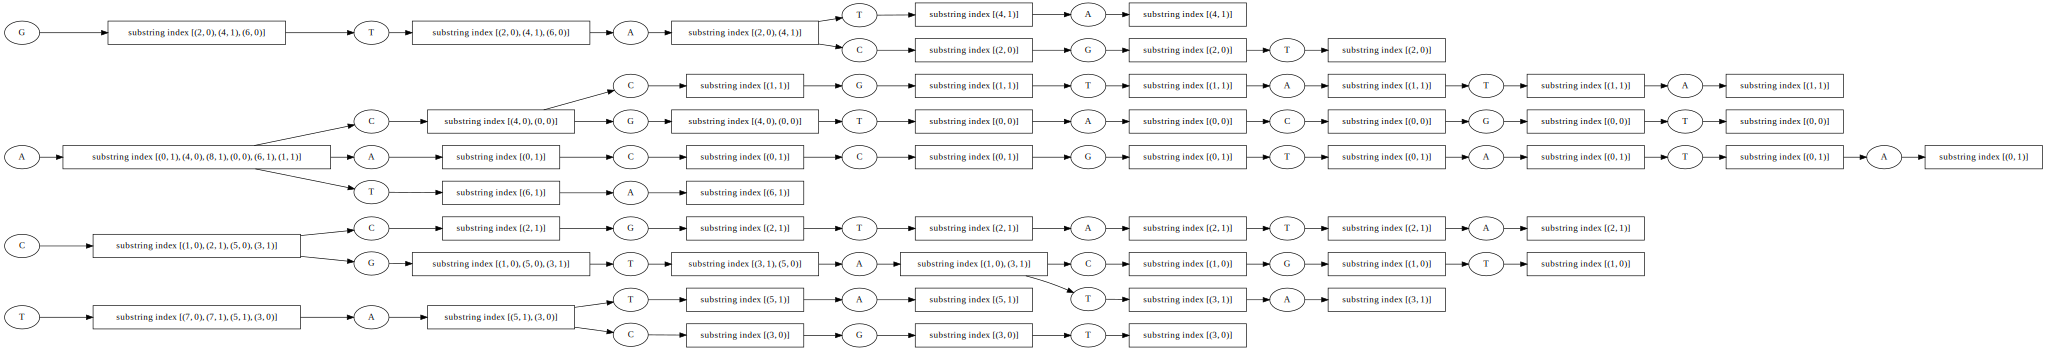

In [16]:
a = PrefixTree(['ACGTACGT','AACCGTATA'])
#CGTA
a.draw_dot()

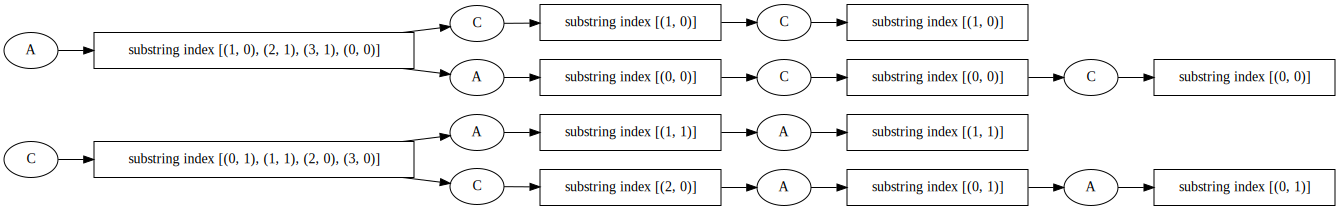

In [17]:
b = PrefixTree(['AACC','CCAA'])
#b = PrefixTree(['AACC'])
b.draw_dot()